# **Integrated EBRAINS pipeline for Functional Connectivity analysis of task-related iEEG data using Frites and EBRAINS resources**

**EITN School Marseille Oct 2025**

Authors: Andrea Brovelli ([BraiNets team](https://brainets.github.io/), [Institut de Neurosciences de la Timone](https://www.int.univ-amu.fr/), Marseille)


## Aim of the Notebook


This Jupiter Notebook is a show case of an integrated pipeline for the functional connectivity analysis of task-related intracranial EEG (iEEG) data. 

The dataset is part of the Human Intracranial Database (HID), which is is a collection of stereotactic electroencephalography (sEEG) data in epileptic patients, performing up to eight behavioral tasks. 

This dataset contains pseudonymized human data. Users can request access using the button below:

Please have a look to the following Knowledge Graph search request https://search.kg.ebrains.eu/instances/bb13d2d1-4609-4790-a20b-678836ad486f.

For the present Notebook, we obtained access to the dataset, we processed the data by removing participant ID and SEEG channel information, selected a specific task (visual search task) and shared the data in the /seeg_data directory

The following Notebok cannot have access directly to the original dataset, because personalised authentication and request must be provided by the KG. Instead, it includes a pipeline based on preprocessed data.

The Notebook uses Frites, which is a Python toolbox for assessing information-theorical measures on human and animal neurophysiological data (M/EEG, Intracranial). 
The aim of Frites is to extract task-related cognitive brain networks (i.e modulated by the task). The toolbox also includes directed and undirected connectivity metrics such as group-level statistics. 
- Frites documentation is available online at https://brainets.github.io/frites/
- [Frites github](https://github.com/brainets/frites)

---


In [1]:
# Imports
import os

import numpy as np
import xarray as xr

import frites
from frites import set_mpl_style
from frites.dataset import DatasetEphy
from frites.workflow import WfMi
from frites.conn import conn_dfc, define_windows, plot_windows

import matplotlib.pyplot as plt

set_mpl_style()

%matplotlib inline

frites.__version__

'0.4.4'

## **Utility function**
---

In [2]:
def plot_stats(mi, pv, use_roi):
    mi, pv = mi.sel(roi=use_roi), pv.sel(roi=use_roi)
    mi.attrs['unit'] = 'bits'
    mi['times'].attrs['unit'] = 'bits'
    mi_s = mi.copy()
    mi_s.data[pv >= 0.05] = np.nan


    fg = mi.plot(x='times', col='roi', color='C3', lw=1, size=5, col_wrap=4)

    for n_ax, ax in enumerate(np.ravel(fg.axes)):
        ax.plot(mi_s['times'].data, mi_s.isel(roi=n_ax).data, lw=3)
        ax.axvline(0., color='C3', linestyle='--')


## **Load iEEG data**

1. Load iEEG data from 59 patients in /data
2. Selected brain areas (use_roi) using parcel names taken from MarsAtlas (https://pubmed.ncbi.nlm.nih.gov/26813563/)
3. Parcel list can be found here https://meca-brain.org/software/marsatlas/
3. Epochs are aligned on stimulus presentation of the visual search task
---

In [5]:
# Select brain regions 
################################################################################
use_roi = [ 'L_Mdl', 'L_Sdl', 'R_Mdl', 'R_Sdl', 'L_SPC', 'L_PMdl', 'R_SPC', 'R_PMdl']
root = 'seeg_data'
################################################################################

# get the list of files
files = os.listdir(root)

data = []
for n_f, f in enumerate(files):
    print(f"Loading subject {n_f + 1} / {len(files)}", end='\r')
    
    # load the data of the subject
    _data = xr.load_dataarray(os.path.join(root, f)).drop('contacts')

    # loop of brain region names to decide which one to keep
    keep = [r in use_roi for r in _data['space'].data]
    
    # if there's no iEEG contact in the selected regions, ignore the subject
    if not np.any(keep):
        continue
    
    # otherwise, keep only the iEEG contacts within the selected roi
    _data = _data.sel(space=keep)
    
    # WARNING = mean activity within parcel because of memory issues
    if len(_data['space'].data) != len(set(_data['space'].data)):
        _data = _data.groupby('space').mean()
    _data['space'] = _data['space'].data.astype(str)

    data.append(_data)

    del _data



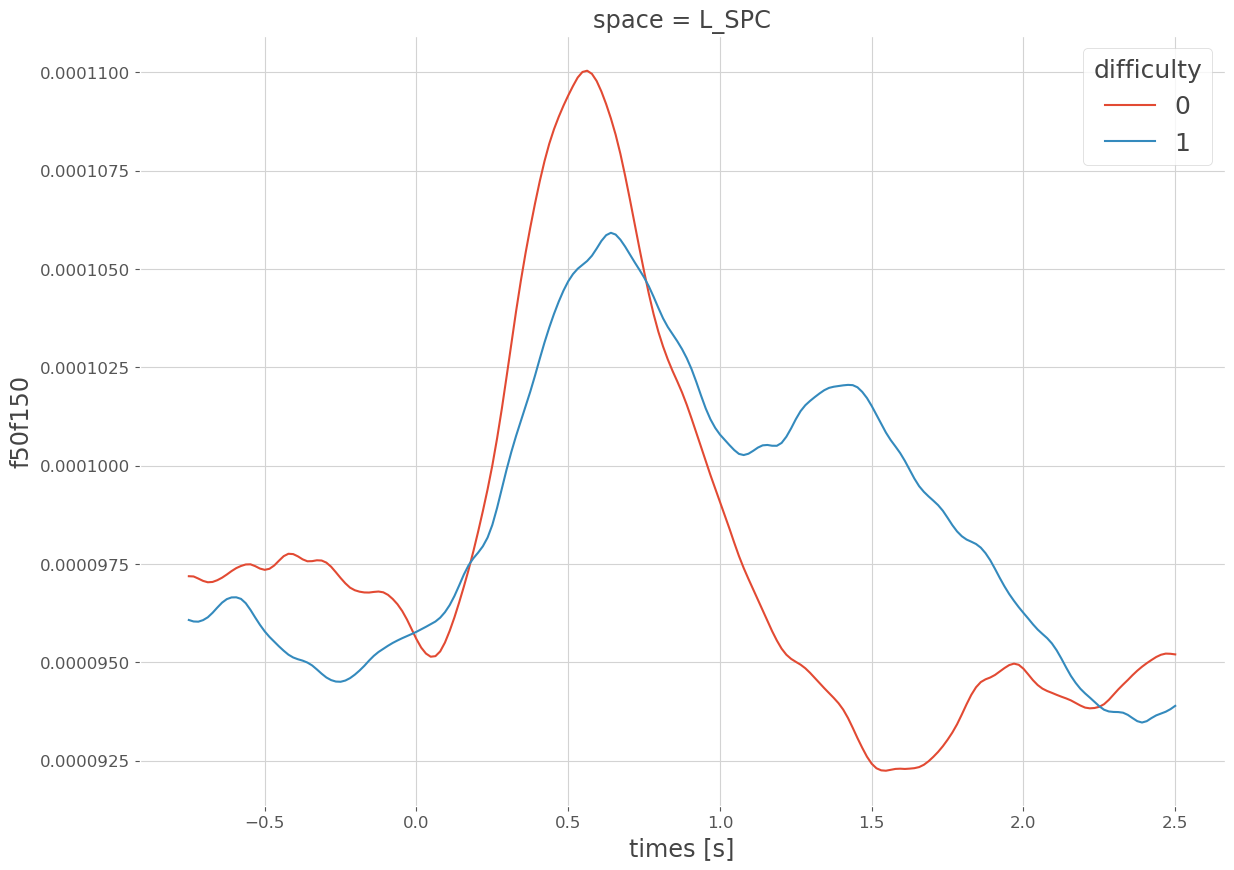

In [6]:
data[0].groupby("difficulty").mean().plot(x="times", hue="difficulty")

# **Plot high-gamma activity (HGA)**

1. Extract high-gamma activity (HGA), which corresponds to the instantaneous power in a frequency band from 50 to 150Hz
2. Compute mean HGA for two experimental conditions (Easy and Hard)
---

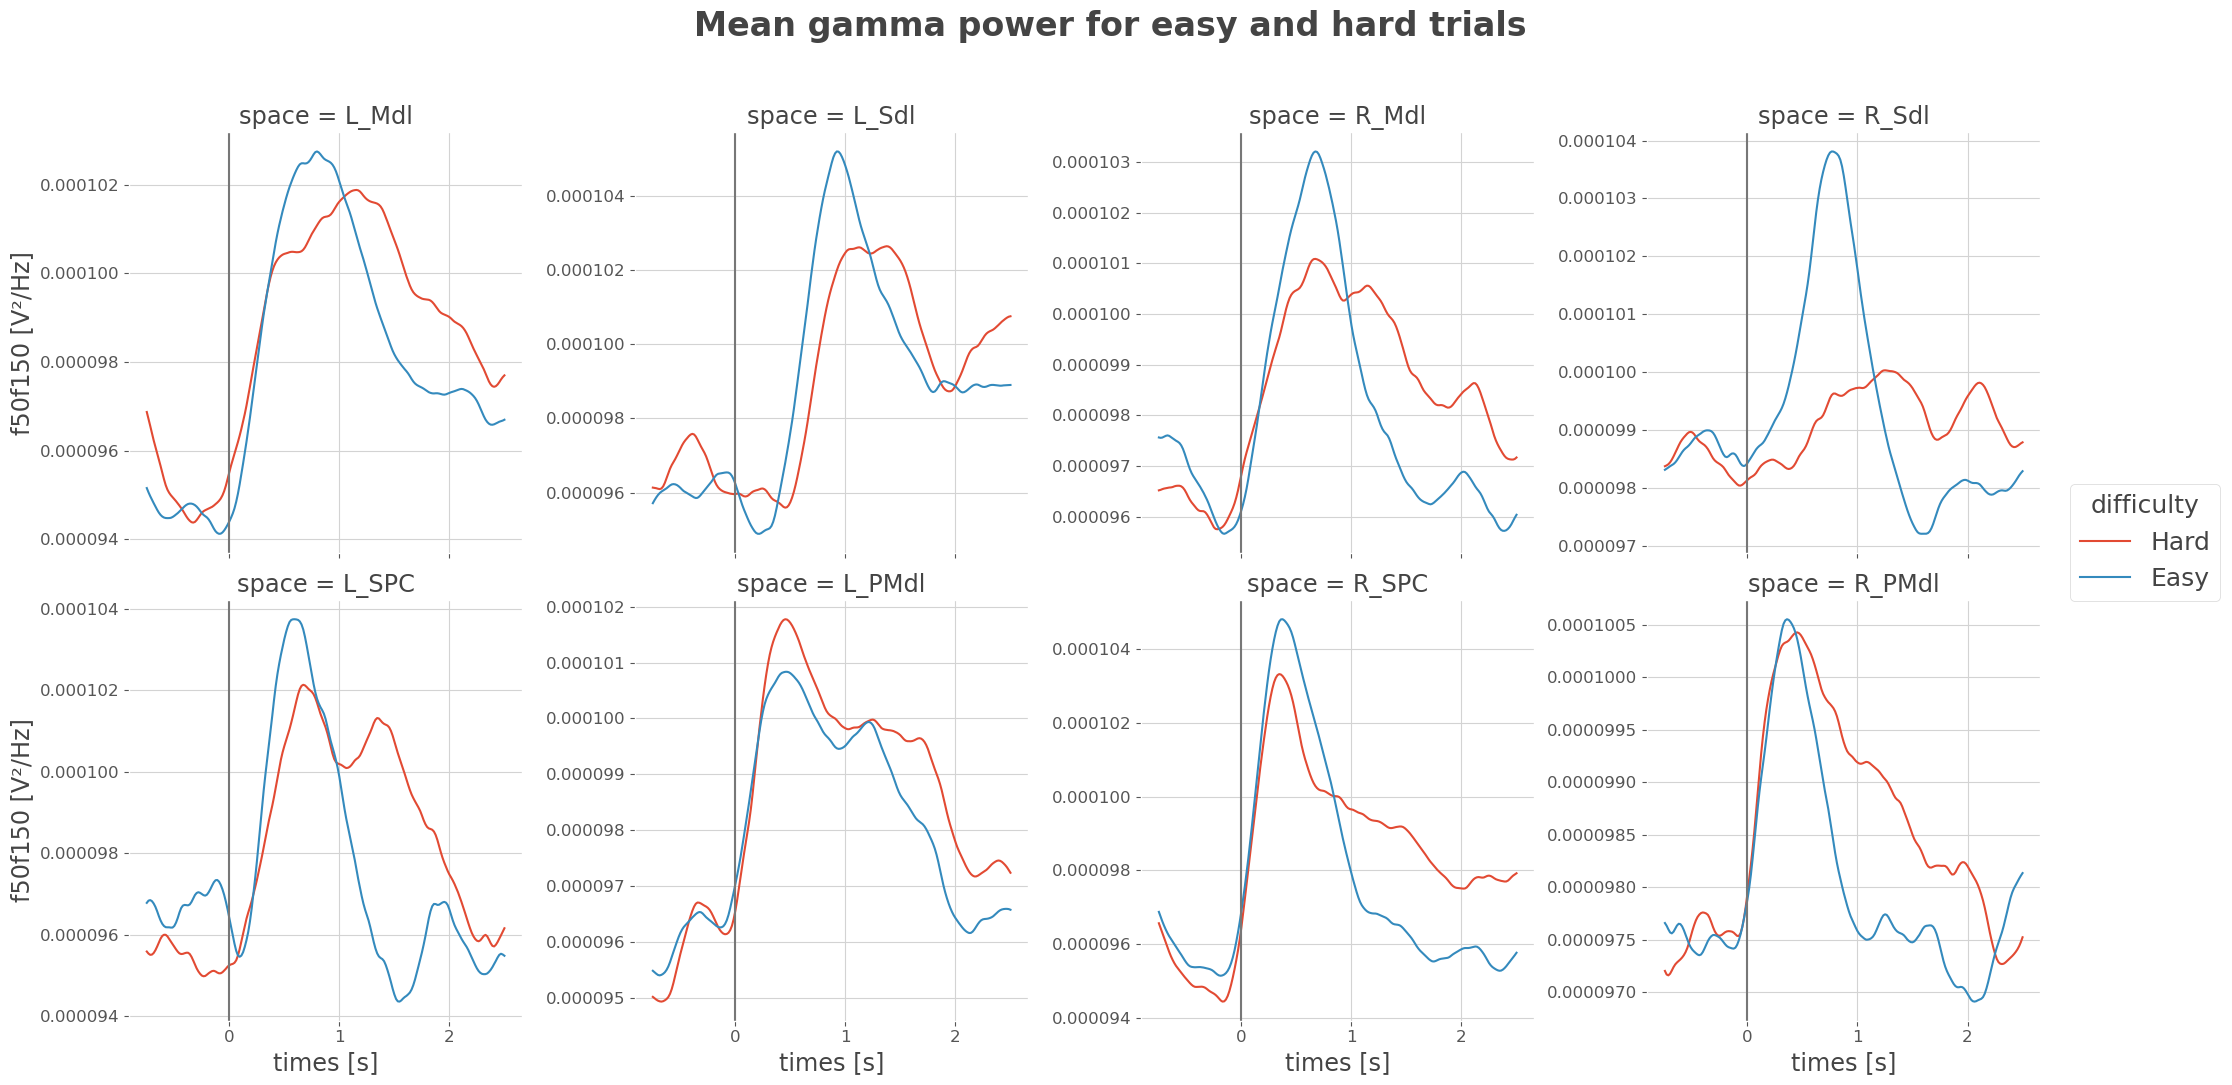

In [7]:
################################################################################
repl_diff = {
    0: "Easy",
    1: "Hard"
}
################################################################################

data_m = []
for d in data:
    d_m = d.groupby('difficulty').mean()
    d_m['difficulty'] = [repl_diff[k] for k in d_m['difficulty'].data]
    data_m.append(d_m)

data_m = xr.concat(data_m, 'space').groupby('space').mean().sel(difficulty=['Hard', 'Easy'], space=use_roi)
data_m.attrs['unit'] = 'V²/Hz'

fg = data_m.plot(x='times', hue='difficulty', col='space', size=5, sharey=False, col_wrap=4)
_ = [ax.axvline(0., color='C3') for ax in np.ravel(fg.axes)]

plt.gcf().suptitle('Mean gamma power for easy and hard trials', y=1.08, fontsize=24, fontweight='bold');

# **Mutual information between HGA and task difficulty**

1. Create a Dataset containing all participants from the xarray
2. Run a group-level (RFX) statistical analysis searching for statistically significant differences in HGA between conditions (Easy vs Hard)
4. The mutual information analysis is performed between continuous (HGA) and discrete (conditions) variables. The mi_type = 'cd' stands for continuous-discrete
5. The workflow return time series of t-values and p-values
6. n_jobs is set to 1 because lab.ebrains allows 1 CPU. Change it otherwise.
---

In [8]:
# Create dataset and Workflow for MI analysis
ds = DatasetEphy(data.copy(), y='difficulty', times='times', roi='space')
wf = WfMi(inference='rfx', mi_type='cd')

Definition of an electrophysiological dataset
    Dataset composed of 25 subjects / sessions
    At least False subjects / roi required
    Supported MI definition I(x; y (discret)) (cd)
Gaussian Copula Mutual Information Estimator (mi_type=cd, copnorm=False, biascorrect=True, demeaned=False)
Definition of a non-parametric statistical workflow
Workflow for computing mutual information (inference=rfx, mi_type=cd, copnorm=True)


In [9]:
# Computer MI and perform permutation-based statistics and cluster-based correction
mi, pv = wf.fit(ds, n_perm=200, mcp='cluster', n_jobs=1)

    Evaluate true and permuted mi (n_perm=200, n_jobs=1)


  0%|          | Estimating MI : 0/8 [00:00<?,       ?it/s]

    T-test across subjects (pop_mean=-0.0014178385334692144; center=False; zscore=False; sigma=0.001)
    Cluster forming threshold (tail=1; alpha=0.05; tfce=None)
    Inference at cluster-level
    Cluster detection (threshold=1.3725050687789917; tail=1)
    Mean mi across subjects


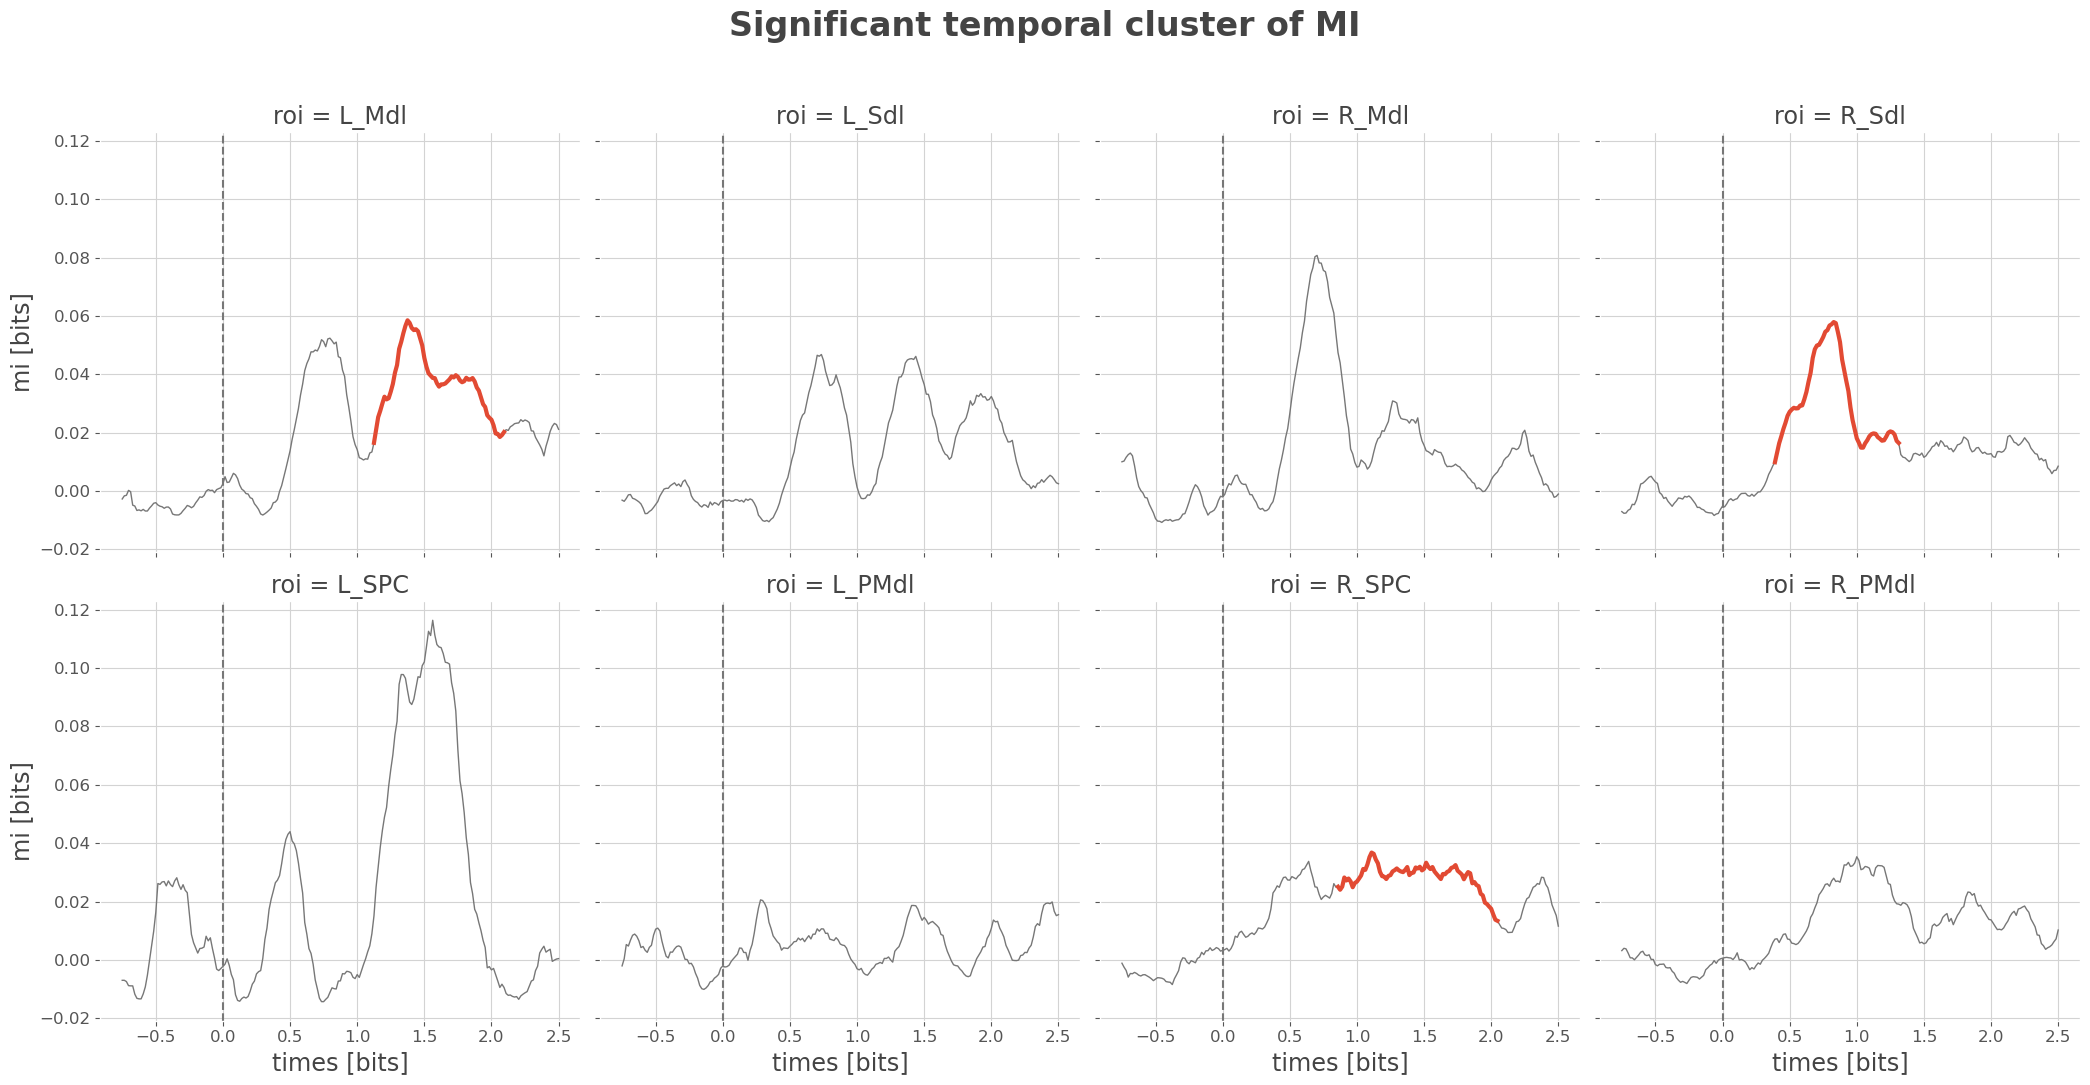

In [11]:
# Plot results with significan clusters in red
plot_stats(mi, pv, use_roi)
plt.gcf().suptitle('Significant temporal cluster of MI', y=1.08, fontsize=24, fontweight='bold');

In [12]:
# Computer MI and perform permutation-based statistics and test-wise FDR correction
mi, pv = wf.fit(ds, n_perm=200, mcp='fdr', n_jobs=1)
wf.clean()
del wf

    True and permuted mutual-information already computed. Use WfMi.clean to reset arguments
    T-test across subjects (pop_mean=-0.0014178385334692144; center=False; zscore=False; sigma=0.001)
    Inference at spatio-temporal level (test-wise)
    Perform correction for MCP (mcp=fdr; tail=1)
    Mean mi across subjects


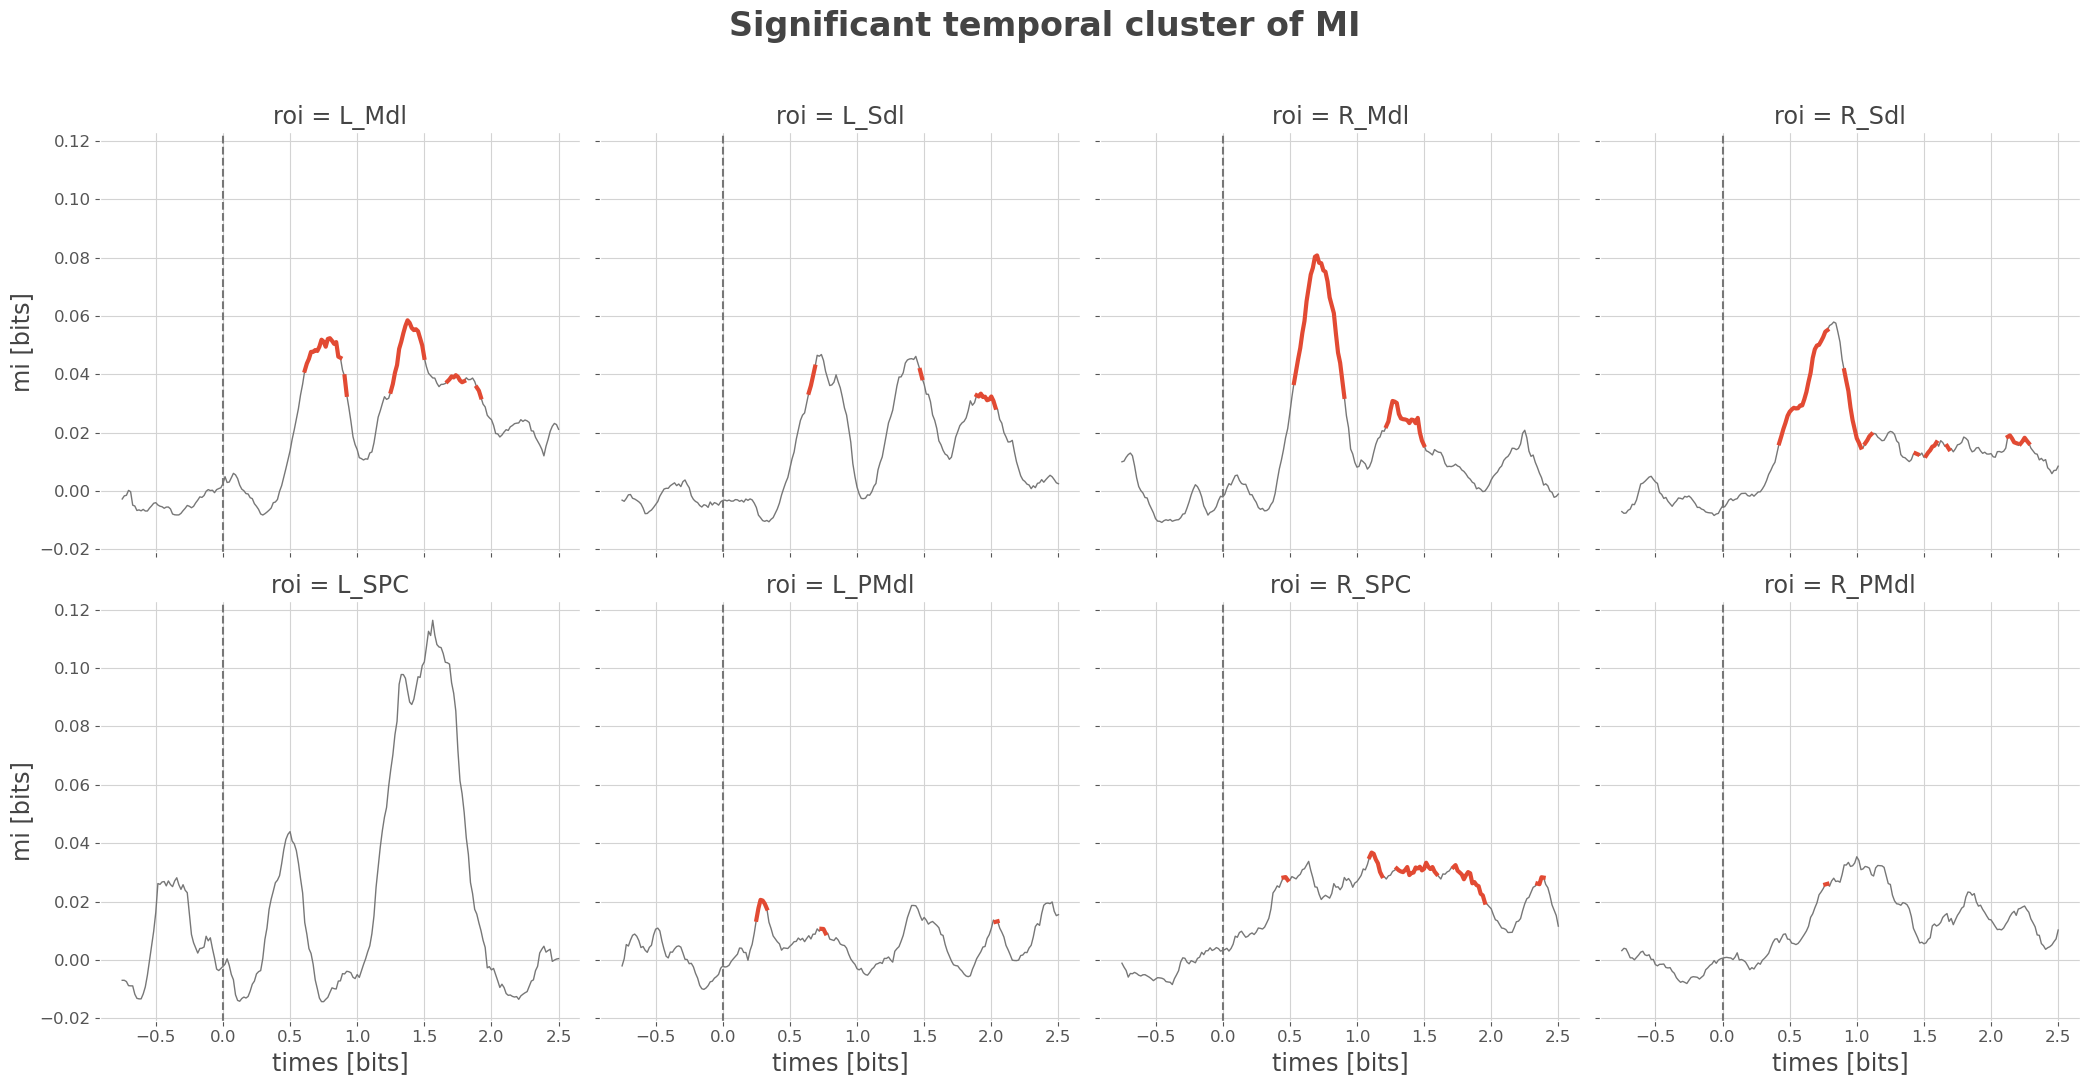

In [13]:
# Plot results with significan time points in red
plot_stats(mi, pv, use_roi)
plt.gcf().suptitle('Significant temporal cluster of MI', y=1.08, fontsize=24, fontweight='bold');

# **Dynamic Functional Connectivity (DFC)**
---

1. Sliding-window approach for the analysis of dynamic functional connectivity
2. We perform single-participant and single-trial DFC estimates


## Sliding windows definition

Defining temporal windows (sfreq=64.0)
    Definition of sliding windows (len=0.5, start=-0.75, stop=2.5, step=0.4)


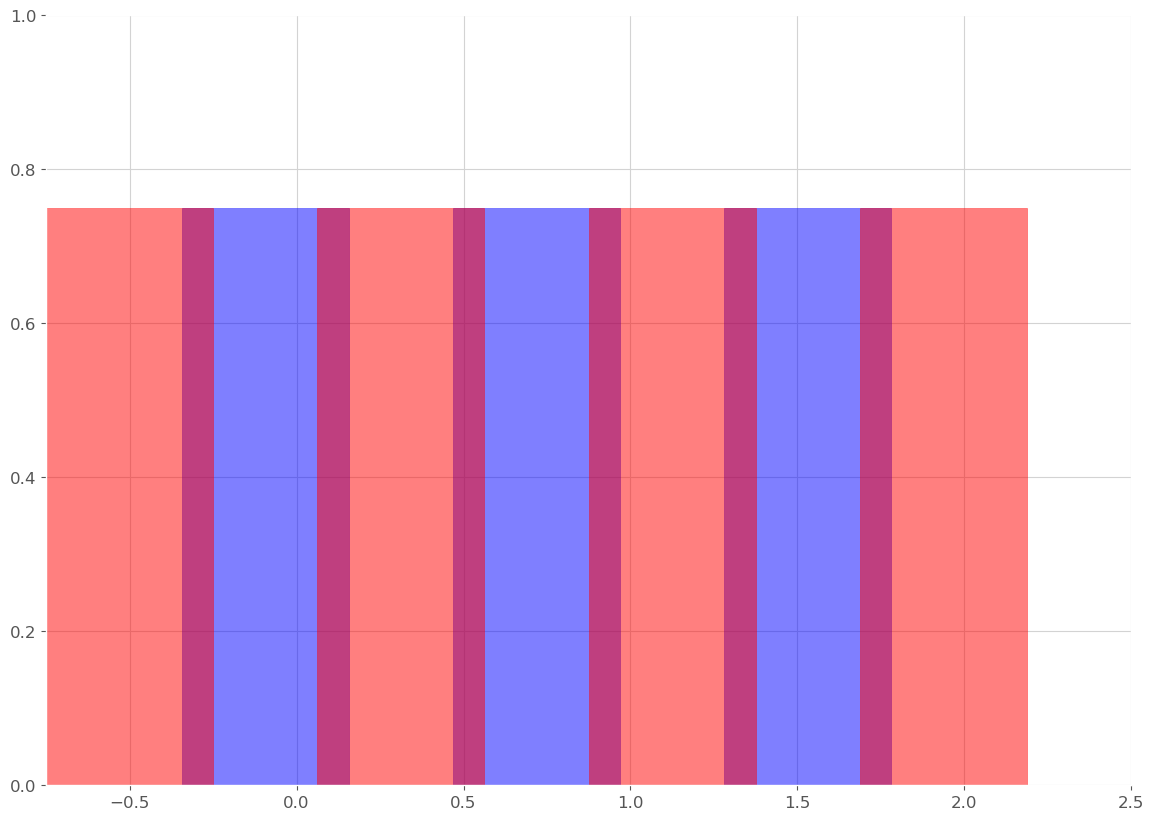

In [14]:
################################################################################
win_len = .5  # seconds
win_step = .4 # seconds
################################################################################

windows, times_win = define_windows(
    data[0]['times'].data, slwin_len=win_len, slwin_step=win_step
)
plot_windows(data[0]['times'].data, windows);

## Single-subject, single-trial DFC

In [15]:
################################################################################
win_len = .5  # seconds
win_step = .025  # seconds
################################################################################

# define sliding windows
windows, times_win = define_windows(
    data[0]['times'].data, slwin_len=win_len, slwin_step=win_step
)

dfc = []
for n_d, d in enumerate(data):
    print(f"DFC of subject {n_d + 1} / {len(data)}", end='\r')
    
    # skip if single brain region
    if len(d['space']) == 1:
        continue
        
    d2 = d.copy()
    d2['trials'] = d['difficulty'].data

    _dfc = conn_dfc(d2, windows, times='times', roi='space', n_jobs=1, verbose=False)
    dfc.append(_dfc)

Defining temporal windows (sfreq=64.0)
    Definition of sliding windows (len=0.5, start=-0.75, stop=2.5, step=0.025)


## Plot DFC for easy / hard trials

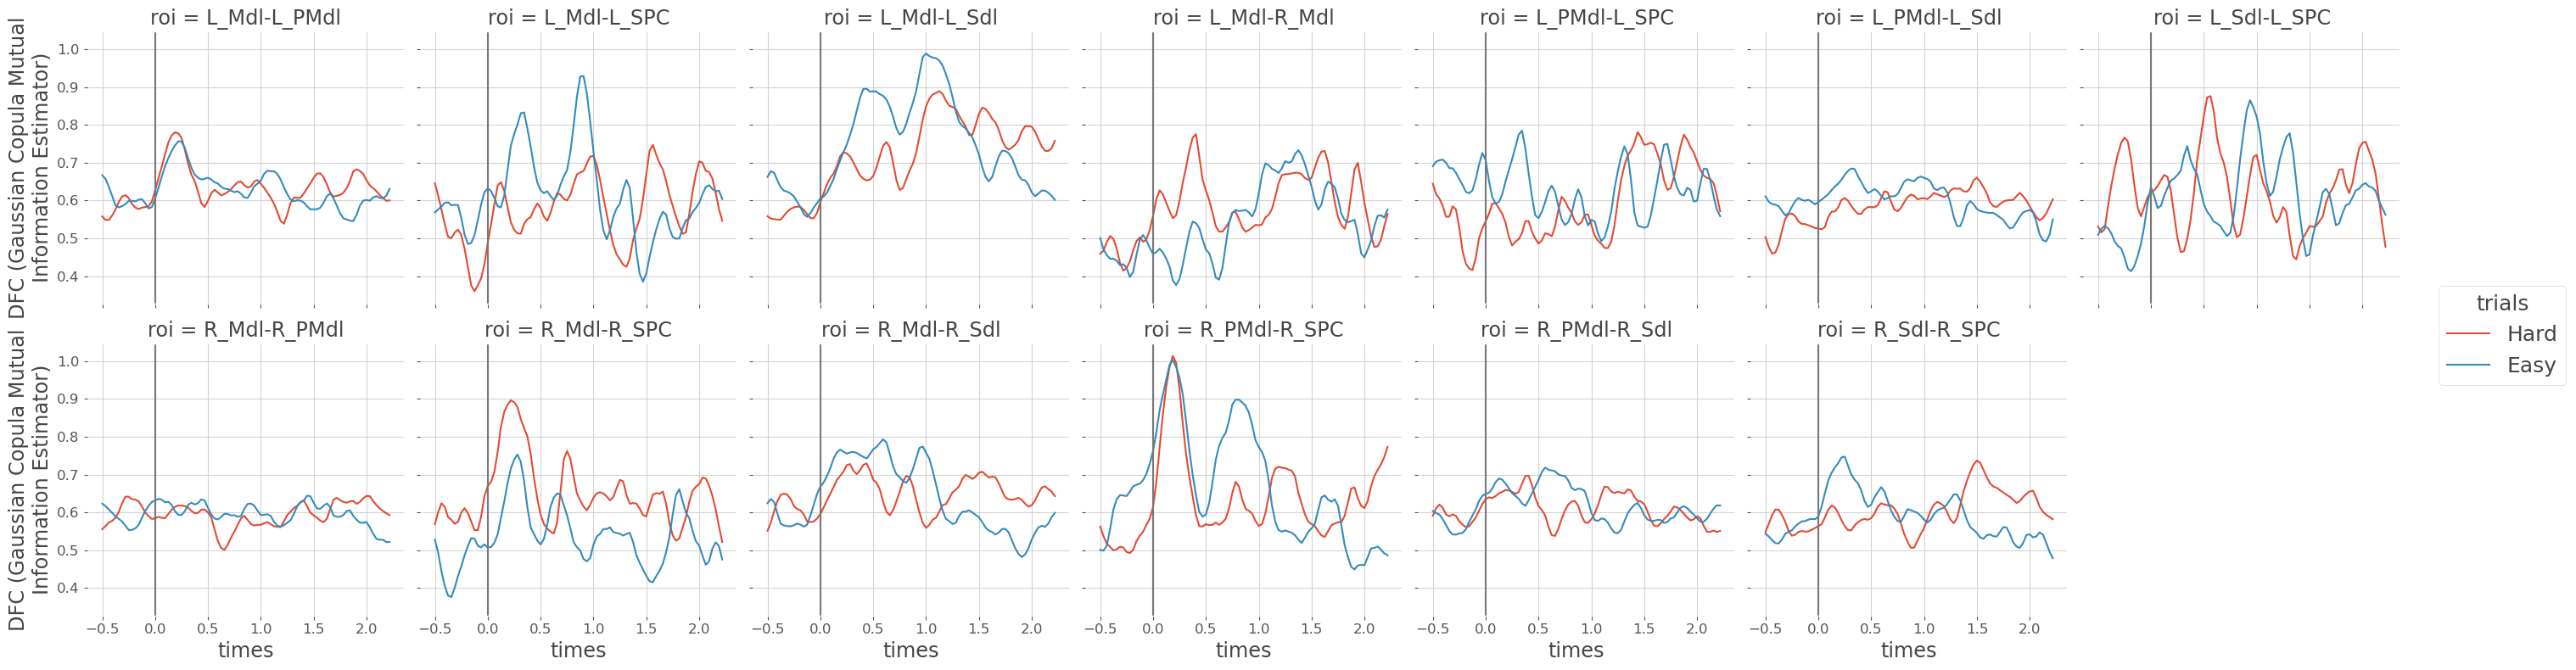

In [16]:
dfc_m = xr.concat([k.groupby('trials').mean() for k in dfc], 'roi').groupby('roi').mean().sel(trials=[1, 0])
dfc_m['trials'] = [repl_diff[k] for k in dfc_m['trials'].data]

fg = dfc_m.plot(x='times', col='roi', size=4, hue='trials', sharey=True, col_wrap=7)
_ = [ax.axvline(0., color='C3') for ax in np.ravel(fg.axes)]

## Task-related DFC

In [17]:
#######################################################################################
# spatial settings
use_pair = ("L_Mdl", "L_Sdl")
# or
use_pair = ("R_PMdl", "R_SPC")

# dfc settings
win_len = .5  # seconds
win_step = .03  # seconds
#######################################################################################

# define sliding windows
windows, times_win = define_windows(
    data[0].sel(times=slice(-.5, 1.5))['times'].data, slwin_len=win_len, slwin_step=win_step
)

# get the list of files
files = os.listdir(root)

dfc_p = []
for n_f, f in enumerate(files):
    print(f"Loading subject {n_f + 1} / {len(files)}", end='\r')
    
    # load the data of the subject
    _data = xr.load_dataarray(os.path.join(root, f)).drop('contacts').sel(times=slice(-.5, 1.5))
    
    # drop the subject if the two brain regions are not present
    r1_in = use_pair[0] in _data['space'].data
    r2_in = use_pair[1] in _data['space'].data
    if not (r1_in and r2_in): continue 

    # loop of brain region names to decide which one to keep
    keep = [r in use_pair for r in _data['space'].data]
    _data = _data.sel(space=keep)
    _data['space'] = _data['space'].data.astype(str)
    _data['trials'] = _data['difficulty'].data
    
    # compute dfc
    _dfc = conn_dfc(
        _data, windows, times='times', roi='space', roi_relation='inter', n_jobs=1, verbose=False
    )
    
    dfc_p += [_dfc.isel(roi=[r]) for r in range(len(_dfc['roi']))]

    del _data




ds = DatasetEphy(dfc_p.copy(), times='times', roi='roi', y='trials', nb_min_suj=2)
wf = WfMi(inference='rfx', mi_type='cd')
mi, pv = wf.fit(ds, n_perm=200, mcp='cluster', n_jobs=1)

Defining temporal windows (sfreq=64.0)
    Definition of sliding windows (len=0.5, start=-0.5, stop=1.5, step=0.03)


Definition of an electrophysiological dataset
    Dataset composed of 135 subjects / sessions


    At least 2 subjects / roi required
    Supported MI definition I(x; y (discret)) (cd)
Gaussian Copula Mutual Information Estimator (mi_type=cd, copnorm=False, biascorrect=True, demeaned=False)
Definition of a non-parametric statistical workflow
Workflow for computing mutual information (inference=rfx, mi_type=cd, copnorm=True)
    Evaluate true and permuted mi (n_perm=200, n_jobs=1)


  0%|          | Estimating MI : 0/1 [00:00<?,       ?it/s]

    T-test across subjects (pop_mean=-0.0013035067334587192; center=False; zscore=False; sigma=0.001)
    Cluster forming threshold (tail=1; alpha=0.05; tfce=None)
    Inference at cluster-level
    Cluster detection (threshold=1.4974099397659302; tail=1)
    Mean mi across subjects


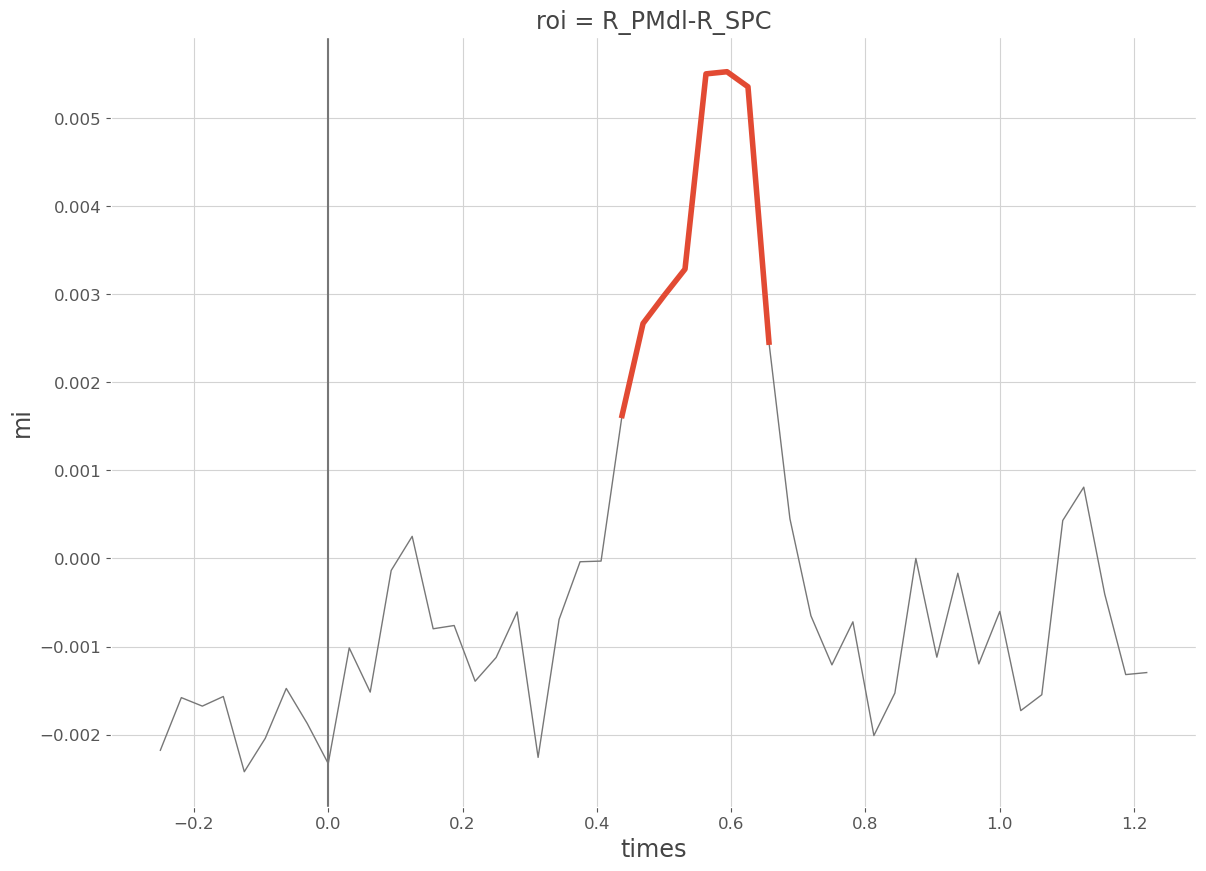

In [18]:
# Plotting results
mi_s = mi.copy()
mi_s.data[pv >= 0.05] = np.nan

mi.plot(color='C3', lw=1)
mi_s.plot(color='C0', lw=4)
plt.axvline(0., color='C3');

# **Correlation between Structural (SC) and dynamic Functional Connectivity (FC)**
---

1. We load group-level SC for MarsAtlas and DFC aligned on stimulus presentation
2. Note that calculations are performed elsewhere
3. We compute the across-channels correlations between SC and dFC


In [17]:
def sc_fc_corr(sc, fc, use_sources, use_targets, seltype=1):
    
    if seltype:
        sc = sc.isel(sources=use_sources, targets=use_targets)
        fc = fc.isel(sources=use_sources, targets=use_targets)
    else:
        sc = sc.sel(sources=use_sources, targets=use_targets)
        fc = fc.sel(sources=use_sources, targets=use_targets)
        
    # indices to flatten squared connectivity
    x_s, x_t = np.triu_indices(len(fc['sources'].data), k=1)
    sc_st = sc.data[x_s, x_t]
    
    n_times = len(fc['times'])
    corr_sfc = np.zeros((n_times,))
    for n_t in range(n_times):
        # temporal selection
        fc_t = fc.data[..., n_t]

        # flatten connectivity
        fc_t = fc_t[x_s, x_t]

        # find missing pairs of regions
        keep = ~np.isnan(fc_t)

        # compute correlation
        corr_sfc[n_t] = np.corrcoef(sc_st[keep], fc_t[keep])[0, 1]

    # xarray transformation
    corr_sc_fc = xr.DataArray(corr_sfc, dims=('times',), coords=(fc['times'].data,))
    
    return corr_sc_fc

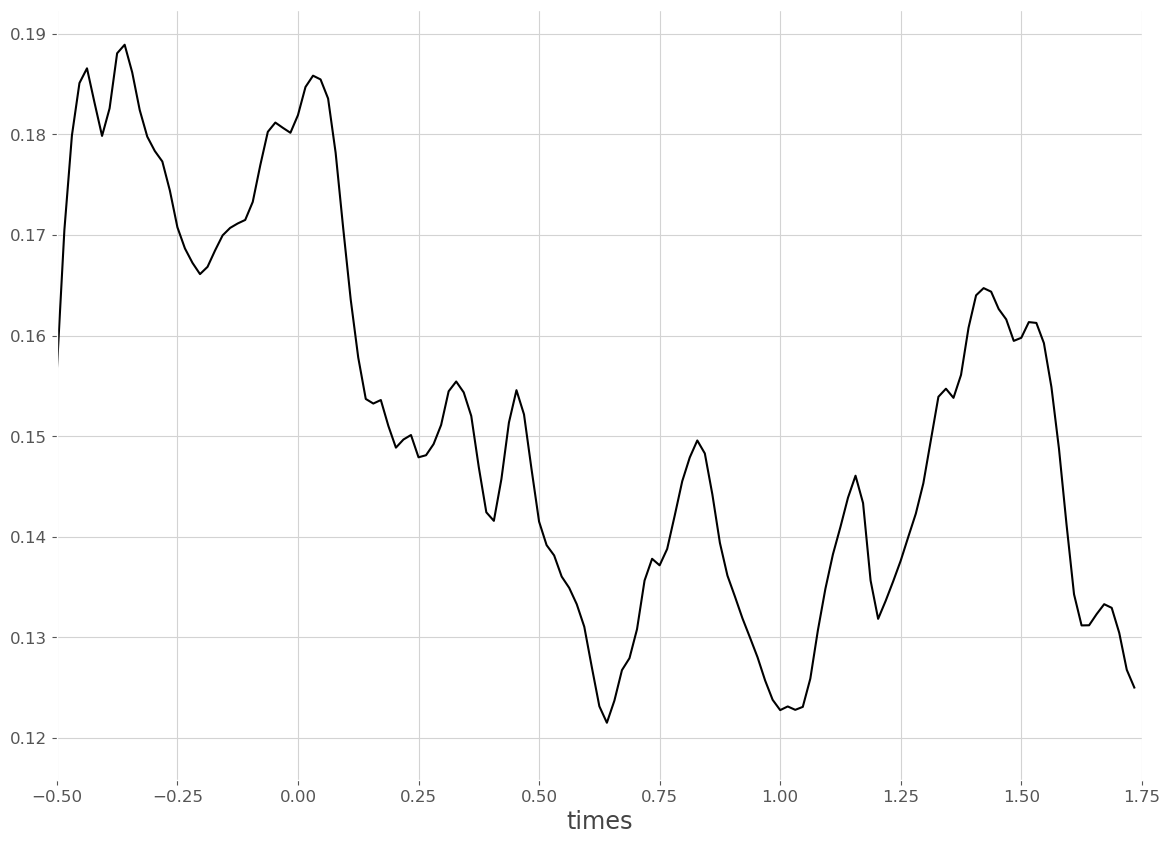

In [18]:
import xarray as xr
import numpy as np

root = 'fcd_sc_group_data'

# load structural and functional connectivity
sc = xr.load_dataarray(os.path.join(root, 'sc.nc'))
fc = xr.load_dataarray(os.path.join(root, 'fc.nc'))

# take only cortical parcels
sc = sc.isel(sources=np.arange(0, 82), targets=np.arange(0, 82))

# indices for lobes
occipital_l = np.arange(0, 5)
parietal_l = np.arange(12, 21)
motor_l = np.arange(21, 27)
prefrontal_l = np.arange(27, 39)
occipital_r = np.arange(0, 5) + 41
parietal_r = np.arange(12, 21) + 41
motor_r = np.arange(21, 27) + 41
prefrontal_r = np.arange(27, 39) + 41

# SC-FC correlation within left hemisphere
use_sources = np.arange(0, 41)
use_targets = np.arange(0, 41)
corr_l_l = sc_fc_corr(sc, fc, use_sources, use_targets)

# SC-FC correlation within right hemisphere
use_sources = np.arange(41, 82)
use_targets = np.arange(41, 82)
corr_r_r = sc_fc_corr(sc, fc, use_sources, use_targets)

# SC-FC correlation across hemispheres
use_sources = np.arange(0, 82)
use_targets = np.arange(0, 82)
corr_l_r = sc_fc_corr(sc, fc, use_sources, use_targets)

# SC-FC correlation for fronto-parietal network
use_sources = np.concatenate((parietal_r, motor_r))
use_targets = np.concatenate((parietal_r, motor_r))
use_sources = prefrontal_l
use_targets = prefrontal_l
corr_fun = sc_fc_corr(sc, fc, use_sources, use_targets)

# SC-FC plotting
corr_l_r.plot(color='k', xlim=[-0.5, 1.75])

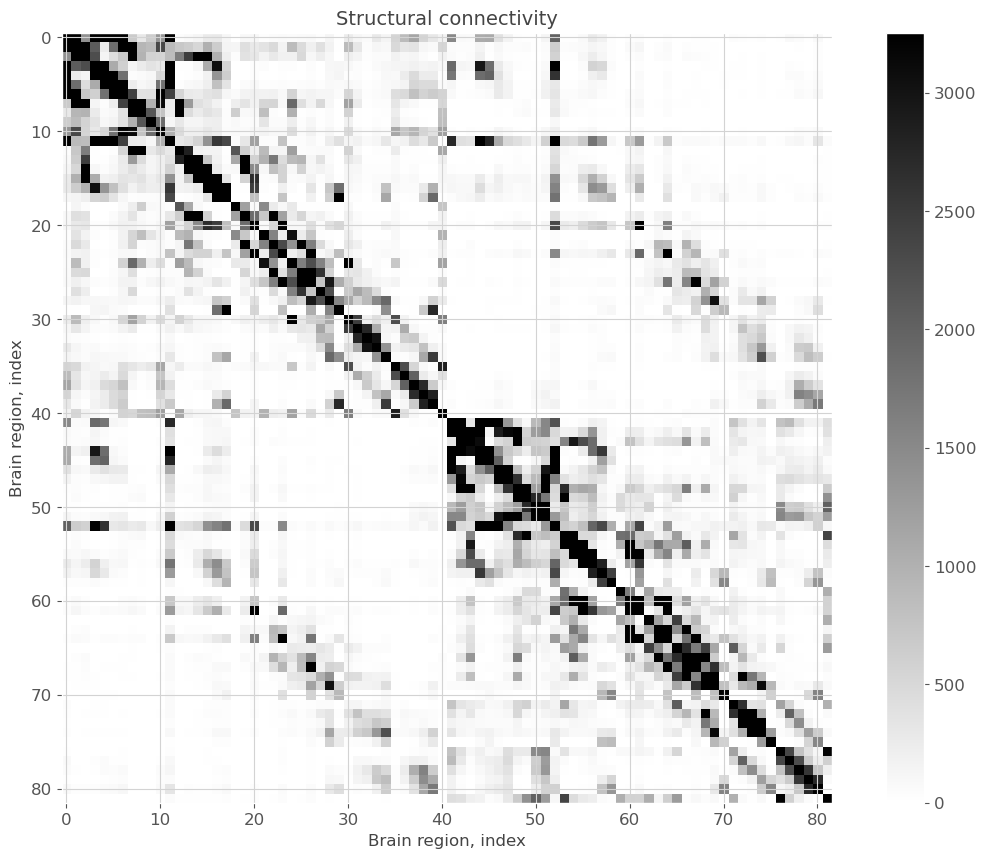

In [19]:
# Visualize structural connectivity matrix
plt.figure()
plt.title("Structural connectivity", fontsize=14)
plt.imshow(sc, cmap='gray_r')
plt.clim(0, 0.1*sc.max())
plt.colorbar()
plt.xlabel('Brain region, index', fontsize=12)
plt.ylabel('Brain region, index', fontsize=12)
plt.show()

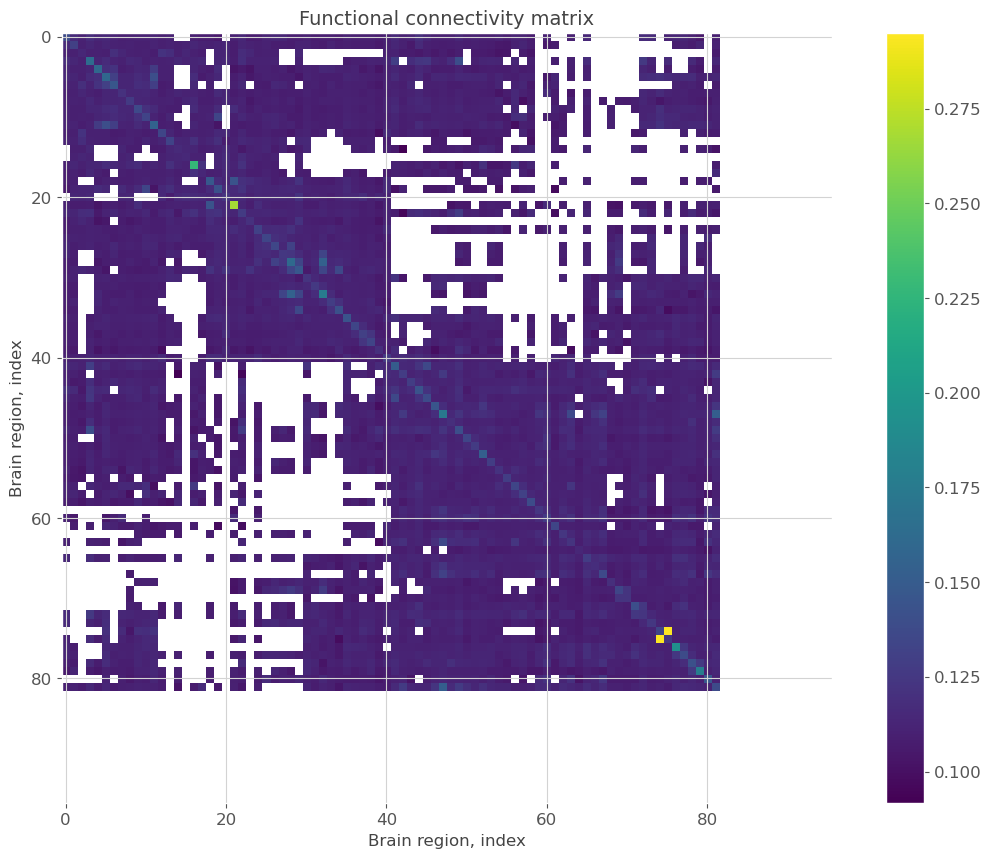

In [20]:
fcm = fc.mean('times')
# np.fill_diagonal(fcm.data, 0)

# Visualize the functional  connectivity matrix
plt.figure()
plt.title("Functional connectivity matrix", fontsize=14)
plt.imshow(fcm, cmap='viridis')
#  plt.clim(0, 0.01*fcm.max())
plt.colorbar()
plt.xlabel('Brain region, index', fontsize=12)
plt.ylabel('Brain region, index', fontsize=12)
plt.show()